In [2]:
import json
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import umap

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1234)

/home/jonathanchen/.pyenv/versions/3.9.5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cpu'

In [4]:
### Paths ###
work_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
art_json = os.path.join(work_dir, 'Datateam/Artificial_imset/artificial_kymographs.json')
exp_json = os.path.join(work_dir, 'Datateam/imset1/experimental_kymograph.json')
models_folder = os.path.join(work_dir, 'DotsTorch/Trained_models/')

In [5]:
# class ArtKymoDataset(Dataset):
#     def __init__(self):
#         # Data loading
#         with open(art_json, 'r') as f:
#             kymos = np.asarray(json.loads(f.read())["kymoset"])

#         # Mean centering to match artificial data
#         for i, kymo in enumerate(kymos):
#             kymos[i] = (kymo - np.mean(kymo)) / np.std(kymo)

#         smaller_extreme = np.min([np.abs(kymos.min()), np.abs(kymos.max())])
#         kymos = np.clip(kymos, -smaller_extreme, smaller_extreme)

#         print(kymos.max())

#         kymos = kymos.astype('float32')

#         kymos = torch.from_numpy(kymos)
#         self.x = kymos
#         self.x = self.x[:,None,:,:]
#         self.n_samples = kymos.shape[0]

#     def __getitem__(self, index):
#         return self.x[index,:,:]

#     def __len__(self):
#         return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))

        smaller_extreme = np.min([np.abs(kymos.min()), np.abs(kymos.max())])
        kymos = np.clip(kymos, -smaller_extreme, smaller_extreme)

        self.x = torch.from_numpy(kymos.astype('float32'))
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return torch.unsqueeze(self.x[:,:,index], 0)

    def __len__(self):
        return self.n_samples

    def numpy(self):
        return self.x.numpy()

In [6]:
dataset = ExpKymoDataset()

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, mu, logsigma, decoder):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.mu = mu
        self.logsigma = logsigma
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

    def forward(self, x):
        h = self.encoder(x)
        mu, logsigma = self.mu(h), self.logsigma(h)

        # resample
        z = mu + torch.exp(logsigma) * torch.randn(mu.shape)

        return mu, logsigma, self.decoder(z)

    def embed(self, x):
        with torch.inference_mode():
            return self.mu(self.encoder(x))

    def loss(self, x, beta = 1):
        mu, logsigma, x_hat = self.forward(x)
        recon = self.mse_loss(x_hat, x)
        kl = torch.mean(0.5 * torch.sum(mu**2 + torch.exp(logsigma)**2 - 2 * logsigma - 1, dim=1))

        return recon + (beta * kl)

In [8]:
def train(dataloader, model, optimizer, beta = 1, device = 'cpu', report_interval = 50):
    """
    Adapted from https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters
    """
    size = len(dataloader.dataset)
    model.to(torch.device(device))
    model.train()

    for batch, X in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        loss = model.loss(X, beta=beta)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if report_interval is not None and batch % report_interval == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
model = VariationalAutoencoder(
    nn.Sequential(
        nn.Conv2d(1, 8, (3, 3), padding='same'),           # N x 8 x 20 x 60
        nn.Tanh(),
        nn.Conv2d(8, 8, (3, 3), stride=2, padding = 1),    # N x 8 x 10 x 30
        nn.Tanh(),

        nn.Conv2d(8, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        nn.Tanh(),

        # nn.Conv2d(16, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        # nn.Tanh(),

        # nn.Conv2d(16, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        # nn.Tanh(),

        nn.Conv2d(16, 16, (3, 3), stride=2, padding = 1),  # N x 16 x 5 x 15
        nn.Tanh(),

        nn.Flatten()
    ),
    nn.Linear(1200, 256),  # mu
    nn.Linear(1200, 256),  # sigma
    nn.Sequential(
        nn.Linear(256, 1200),
        # nn.Unflatten(1, (1, 20, 60)),  # N x 1 x 20 x 60, let's be lazy
        # nn.Conv2d(1, 1, (3, 3), padding='same'),
        # nn.Conv2d(1, 1, (3, 3), padding='same'),
        # nn.ReLU()

        nn.Unflatten(1, (16, 5, 15)),

        # U-net style "up-conv"
        nn.Upsample(scale_factor=2, mode='bilinear'), # N x 16 x 10 x 30
        nn.Conv2d(16, 8, (3, 3), padding='same'),     # N x 8 x 20 x 30
        nn.Tanh(),

        # U-net style "up-conv"
        nn.Upsample(scale_factor=2, mode='bilinear'), # N x 8 x 20 x 60
        nn.Conv2d(8, 1, (3, 3), padding='same'),      # N x 1 x 20 x 60
        nn.Tanh(),
    )
)

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epoch = 200
losses = np.zeros(num_epoch)

loader = DataLoader(dataset, batch_size=8, shuffle=True)

for epoch in range(num_epoch):
    start_time = time.perf_counter()

    train(loader, model, opt, beta=0.0001, device=device, report_interval=None)

    X_val = torch.permute(
        # sample 10 random examples to validate with
        dataset[torch.randint(len(dataset), size=(50,))],
        # reshape to [N, C, H, W]
        (3, 0, 1, 2)
    )

    with torch.inference_mode():
        losses[epoch] = loss = model.loss(X_val.to(device)).item()
    
    elapsed = time.perf_counter() - start_time

    print(f"Epoch: {epoch + 1} time: {elapsed:0.2f}s loss: {loss:0.4f}")
else:
    save_model = True
    model_name = f'JC_model.{num_epoch}.pt'

    if save_model:
        torch.save(model.state_dict(), os.path.join(models_folder, model_name))

Epoch: 1 time: 0.19s loss: 10.6224
Epoch: 2 time: 0.14s loss: 8.6068
Epoch: 3 time: 0.15s loss: 5.1893
Epoch: 4 time: 0.17s loss: 12.6211
Epoch: 5 time: 0.16s loss: 12.5711
Epoch: 6 time: 0.15s loss: 8.4523
Epoch: 7 time: 0.17s loss: 7.7069
Epoch: 8 time: 0.15s loss: 9.0186
Epoch: 9 time: 0.15s loss: 7.6953
Epoch: 10 time: 0.17s loss: 7.9126
Epoch: 11 time: 0.17s loss: 8.2454
Epoch: 12 time: 0.14s loss: 7.2427
Epoch: 13 time: 0.14s loss: 6.9185
Epoch: 14 time: 0.15s loss: 7.5141
Epoch: 15 time: 0.15s loss: 5.5415
Epoch: 16 time: 0.15s loss: 8.3240
Epoch: 17 time: 0.16s loss: 6.0878
Epoch: 18 time: 0.13s loss: 5.4435
Epoch: 19 time: 0.14s loss: 5.8536
Epoch: 20 time: 0.16s loss: 8.3889
Epoch: 21 time: 0.16s loss: 5.4196
Epoch: 22 time: 0.14s loss: 8.9500
Epoch: 23 time: 0.16s loss: 5.3011
Epoch: 24 time: 0.15s loss: 7.3283
Epoch: 25 time: 0.16s loss: 11.1948
Epoch: 26 time: 0.16s loss: 7.5091
Epoch: 27 time: 0.15s loss: 7.6817
Epoch: 28 time: 0.14s loss: 7.4506
Epoch: 29 time: 0.14s los

Text(0, 0.5, 'Loss')

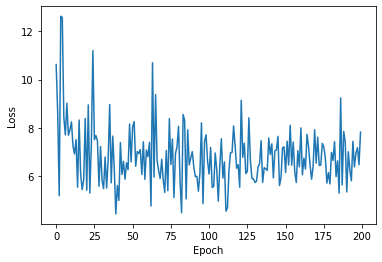

In [16]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [17]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(model, data, dims=None):
    embeddings = np.zeros((256, len(dataset)))

    with torch.inference_mode():
        for (i, x) in enumerate(data):
            z = model.embed(x.unsqueeze(0).to(device))
            embeddings[:, i] = z.detach().to('cpu').numpy().squeeze()

    if dims is not None and isinstance(dims, list):
        plt.scatter(embeddings[dims[0], :], embeddings[dims[1], :], c='r', alpha = 0.3)

        plt.xlabel(f'Latent Dim {dims[0]}')
        plt.ylabel(f'Latent Dim {dims[1]}')
        plt.legend(loc='upper right')
        plt.title('Kymograph position in Latent Space')
        plt.legend
    else:
        reducer = umap.UMAP(random_state=42)
        reducer.fit(embeddings)
        u = reducer.fit_transform(embeddings)

        plt.scatter(u[:, 0], u[:, 1])
        plt.xlabel("U1")
        plt.ylabel("U2")


#pick random kymographs to reconstruct and show
def plot_sample_im(model, data):
    plt.figure(figsize=(12,5))

    idx = np.random.randint(len(dataset), size=3)

    for i, id in enumerate(idx):
        x = data[id]

        with torch.inference_mode():
            _, _, x_hat = model(x.unsqueeze(0).to(device))
            x_hat = x_hat.detach().to('cpu').numpy()

        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(x.squeeze(), cmap='gray')

        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(x_hat.squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

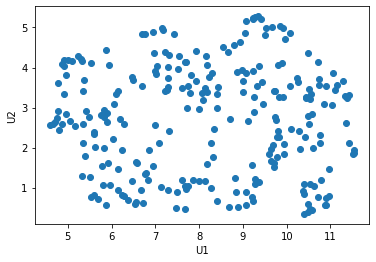

In [30]:
plot_latent(model, dataset, dims=None)

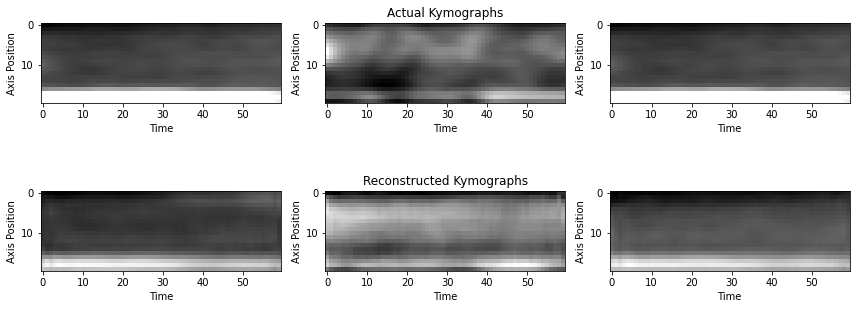

In [31]:
plot_sample_im(model, dataset)